# FDSN webservice with Obspy- Dataselect service

In this tutorial we will get the wavefrom data from one station.

### Getting Started - Import Modules

In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client as FDSN_Client

### Define GeoNet FDSN client

In [2]:
client = FDSN_Client("GEONET")
client_nrt = FDSN_Client("https://service-nrt.geonet.org.nz")

## Accessing Waveforms
Use the **dataselect** service to access waveforms from the archive.

Data are returned as a stream object, which is made up of a number of traces. 

You can filter data requests by time, station, channel, etc, and you can use UNIX wildcards in the request.

This first example requests 5 minutes (300 seconds) of waveforms recorded at THZ at the time of the 2016 Kaikoura earthquake. This station has two sensors, with location codes 10 and 21, and each provides three components of data. `*` matches all location codes, and `HH?` matches all component names that start with `HH`. We also request the instrument response.

In [3]:
t = UTCDateTime("2016-11-13T11:02:30.000")
st = client.get_waveforms("NZ", "THZ","*", "H??", t, t + 300,attach_response=True)
print(st)

6 Trace(s) in Stream:
NZ.THZ.10.HHE | 2016-11-13T11:02:30.003189Z - 2016-11-13T11:07:30.003189Z | 100.0 Hz, 30001 samples
NZ.THZ.10.HHN | 2016-11-13T11:02:30.003189Z - 2016-11-13T11:07:30.003189Z | 100.0 Hz, 30001 samples
NZ.THZ.10.HHZ | 2016-11-13T11:02:30.003190Z - 2016-11-13T11:07:30.003190Z | 100.0 Hz, 30001 samples
NZ.THZ.21.HNE | 2016-11-13T11:02:30.005000Z - 2016-11-13T11:07:30.005000Z | 200.0 Hz, 60001 samples
NZ.THZ.21.HNN | 2016-11-13T11:02:30.005000Z - 2016-11-13T11:07:30.005000Z | 200.0 Hz, 60001 samples
NZ.THZ.21.HNZ | 2016-11-13T11:02:30.005000Z - 2016-11-13T11:07:30.005000Z | 200.0 Hz, 60001 samples


Plot the first three channels which are ground velocity, and then the next three which are ground acceleration

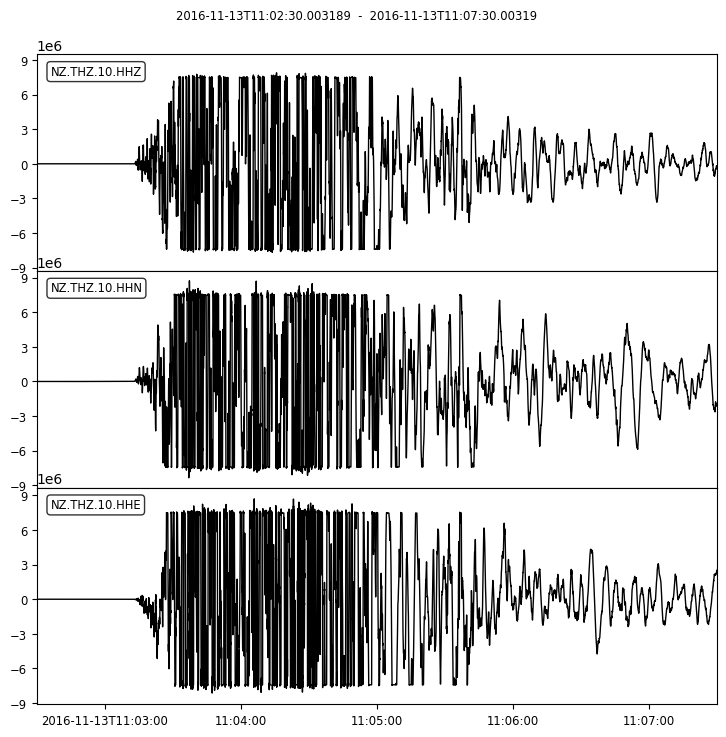

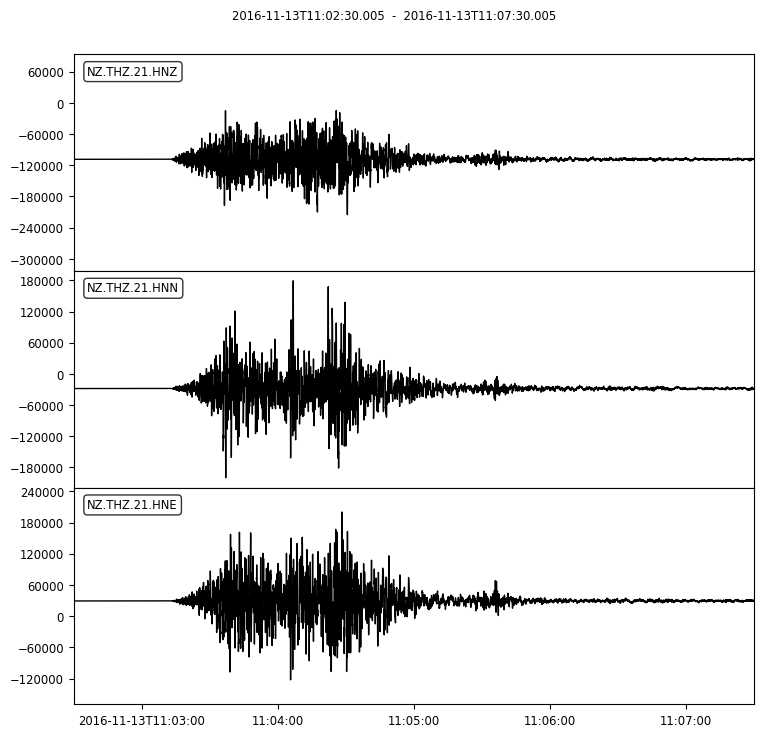

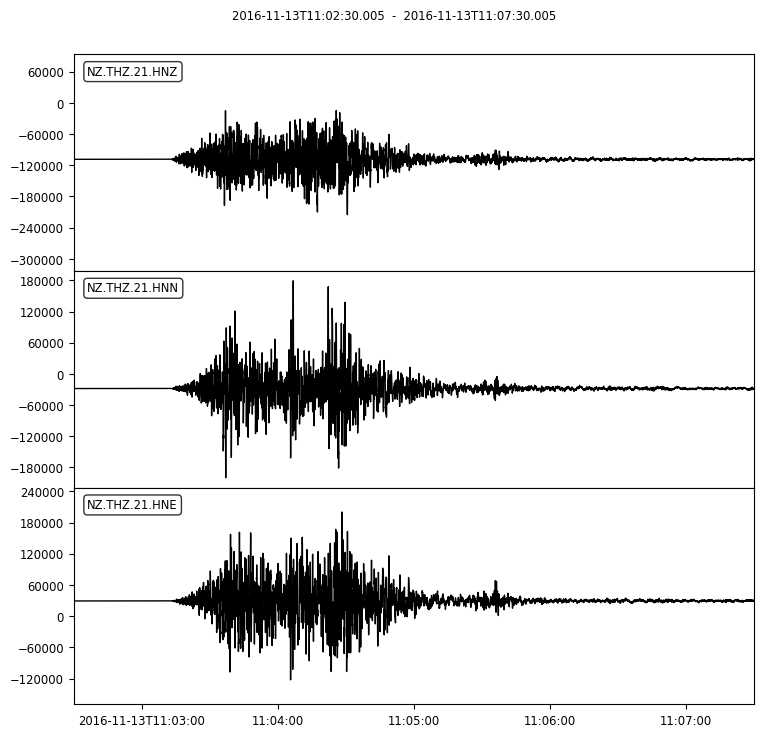

In [4]:
st[0:3].plot() #velocity
st[3:6].plot() #acceleration

### Remove instrument response

We remove the instrument response from the acceleration records so that we can determine the peak ground accelerations measured on each channel.

In [5]:
pre_filt = (0.025, 0.03, 70.0, 80.0)
acc = st[3:6]
acc.remove_response(output='ACC', pre_filt=pre_filt)
pga = acc.max()
print('PGA (HNE) = %f, PGA (HNN) = %f, PGA (HNZ) = %f m/s/s ' % (pga[0],pga[1],pga[2]))

PGA (HNE) = 0.402339, PGA (HNN) = 0.485368, PGA (HNZ) = -0.249306 m/s/s 


### Coastal sea level gauge example

The same procedure for accessing waveform from a FDSN waveserver applies to data from coastal sea level gauges. We'll get data from `GIST`, the gauge at Gisborne. The location code is `40` and the component is `BTH`. We retrieve a day of data from 2022-01-15, the day of the Hunga Tonga - Hunga Ha'apai volcanic eruption generated tsunami. 

In [6]:
t = UTCDateTime("2022-01-15T05:00:00.000")
st = client.get_waveforms("NZ", "GIST","40", "BTH", t, t + 86400,attach_response=True)
print(st)

1 Trace(s) in Stream:
NZ.GIST.40.BTH | 2022-01-15T05:00:00.000000Z - 2022-01-16T05:00:00.000000Z | 10.0 Hz, 864001 samples


Remove the sensitivity to convert the vaues into metres of water above the sensor.

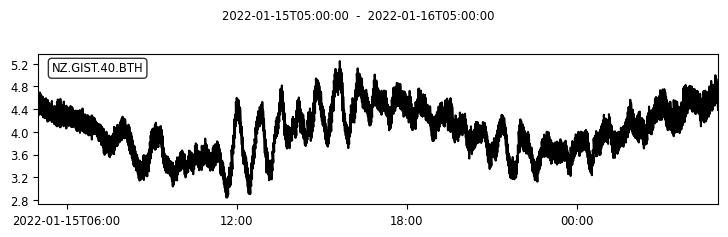

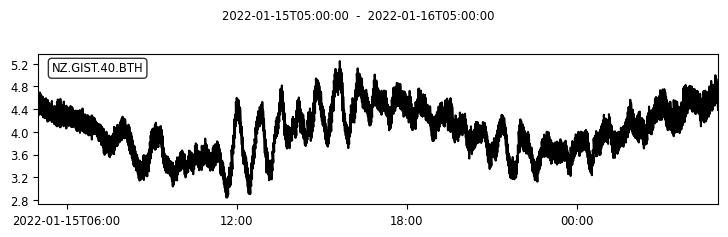

In [7]:
st.remove_sensitivity()
st.plot()

### Day length plot

Another common request is to view an entire day worth of data at a site.
This example shows a swarm of volcanic at Mt Ruapehu in 2016. We retrieve 86400 seconds, equivalent of a whole day, of data.

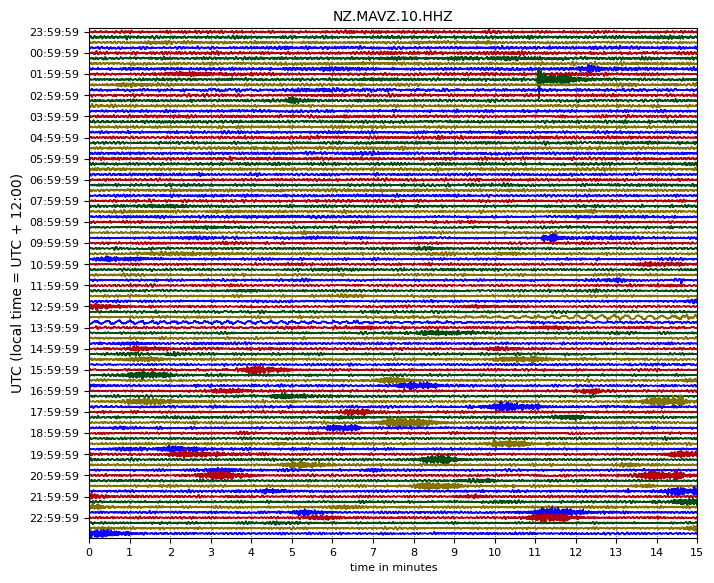

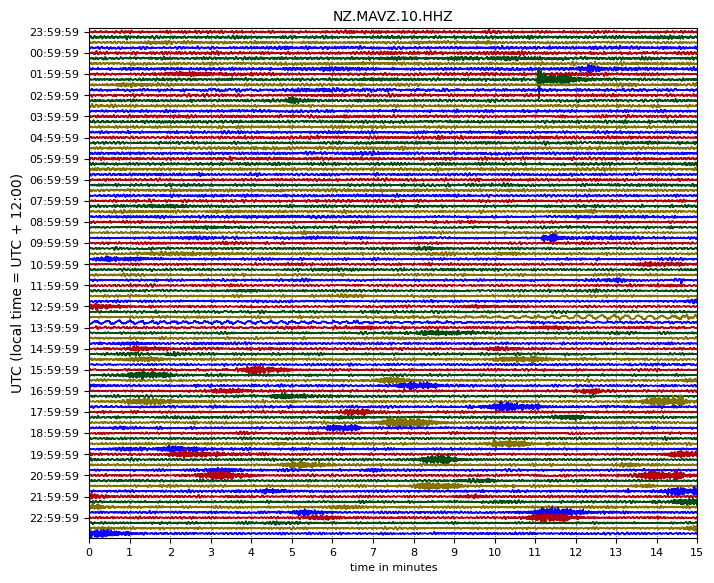

In [8]:
t = UTCDateTime("2016-04-27T00:00:00.000")
st = client.get_waveforms("NZ", "MAVZ","10", "HHZ", t, t + 86400)
st.plot(type="dayplot")

### Spectrogram plots

These are also easy with obspy. We request 1 hour (3600 seconds) of data. While a spectrogram can be plotted for any data window, it becomes very slow for longer windows. One hour of data takes several seconds to plot, and much longer windows are not recommended.

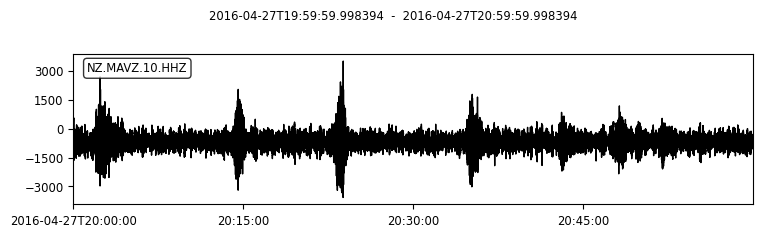

<Figure size 432x288 with 0 Axes>

[None]

In [9]:
t = UTCDateTime("2016-04-27T20:00:00.000")
st.trim(t,t+3600)
st.plot() 
st.spectrogram(log=True)

### Day length plot for most recent data

At the beginning of this workbook we defined two clients. One for the archive services, which we have been using so far, and the other for the near real-time service. This example uses the near real-time service to show the most recent day's data recorded at a site. 

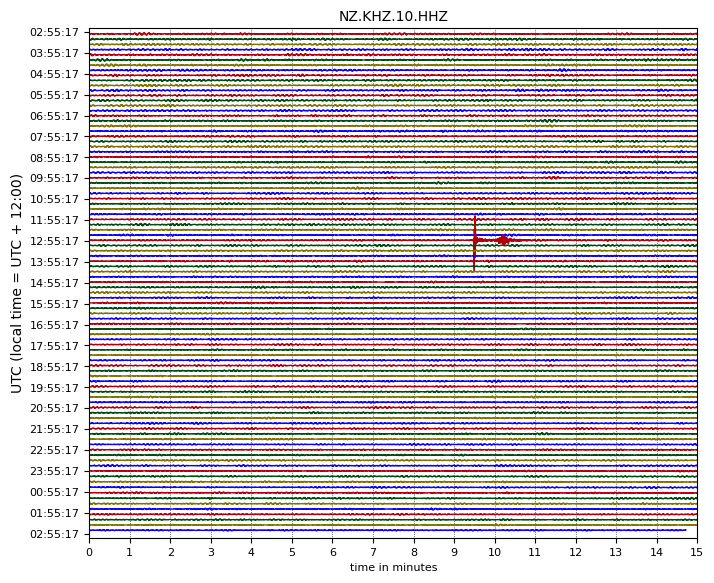

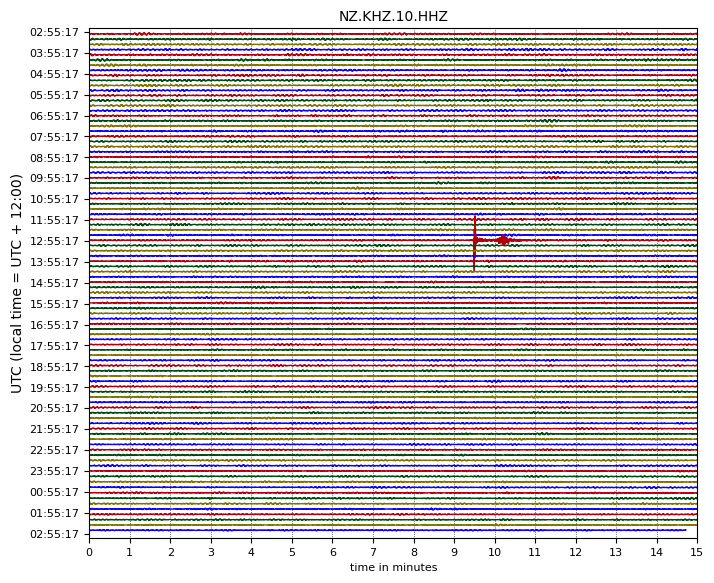

In [10]:
t = UTCDateTime.now()
st = client_nrt.get_waveforms("NZ", "KHZ", "10", "HHZ",t-86400,t)
st.plot(type="dayplot")

Based on the day plot, the data look continuous, but there might be small data gaps caused by communications issues. If this is the case, then the stream will consist of several traces

In [11]:
st

1 Trace(s) in Stream:
NZ.KHZ.10.HHZ | 2023-04-27T02:55:17.570000Z - 2023-04-28T02:54:55.980000Z | 100.0 Hz, 8637842 samples

We get some basic attributes to tell us a bit more about the first trace in the stream. If the stream consists of only one trace then this information will refer to the whole day of data requested.

In [12]:
print(st[0].stats)

               network: NZ
               station: KHZ
              location: 10
               channel: HHZ
             starttime: 2023-04-27T02:55:17.570000Z
               endtime: 2023-04-28T02:54:55.980000Z
         sampling_rate: 100.0
                 delta: 0.01
                  npts: 8637842
                 calib: 1.0
_fdsnws_dataselect_url: https://service-nrt.geonet.org.nz/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'D', 'number_of_records': 20984, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 512, 'filesize': 10743808})
            processing: ['ObsPy 1.4.0: trim(endtime=UTCDateTime(2023, 4, 28, 2, 55, 17, 570000)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2023, 4, 27, 2, 55, 17, 570000))']
